# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): **Michelle Ho (Chia Chi Ho)**

Enrollment Status (109A, 121A, 209A, or E109A): **I'm in AC209a. My partner is in CS109A.**

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

/Users/jasminetong/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [2]:
# your code here
# Build dataframe for training & test data 
train_df = pd.read_csv('data/Bikeshare_train.csv', index_col = 0)
test_df = pd.read_csv('data/Bikeshare_test.csv', index_col = 0)

In [3]:
train_df.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


In [4]:
test_df.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,1.0,2.0,0.0,4.0,1.0,1.0,2.0,6.0,56.2083,0.194037,3830.0
1,1.0,12.0,0.0,4.0,1.0,2.0,1.0,3.0,65.2917,0.350133,2114.0
2,2.0,6.0,0.0,4.0,1.0,2.0,36.0,37.0,56.8333,0.149883,915.0
3,1.0,2.0,0.0,1.0,1.0,1.0,8.0,12.0,49.0833,0.268033,4322.0
4,2.0,5.0,0.0,0.0,0.0,1.0,28.0,29.0,69.7083,0.215171,6591.0


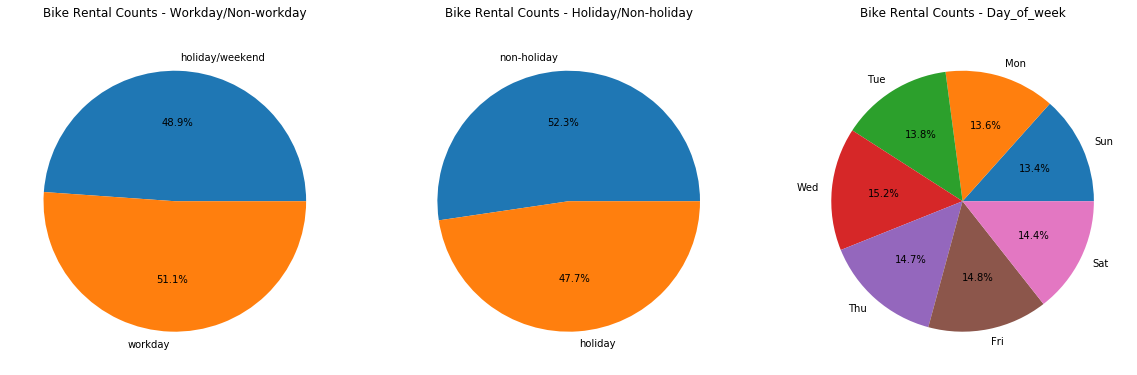

In [6]:
# Looking at how workday/holiday/day_of_week relate to bike rentals
fig, axarr = plt.subplots(1, 3, figsize=(20, 6))

workingday_labels = ['holiday/weekend', 'workday']
workingday_values = train_df.groupby('workingday')['count'].mean()

holiday_labels = ['non-holiday', 'holiday']
holiday_values = train_df.groupby('holiday')['count'].mean()

day_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
day_values = train_df.groupby('day_of_week')['count'].mean()

axarr[0].pie(workingday_values, labels = workingday_labels, autopct='%1.1f%%')
axarr[0].set_title('Bike Rental Counts - Workday/Non-workday\n')

axarr[1].pie(holiday_values, labels = holiday_labels, autopct='%1.1f%%')
axarr[1].set_title('Bike Rental Counts - Holiday/Non-holiday\n')

axarr[2].pie(day_values, labels = day_labels, autopct='%1.1f%%')
axarr[2].set_title('Bike Rental Counts - Day_of_week\n')


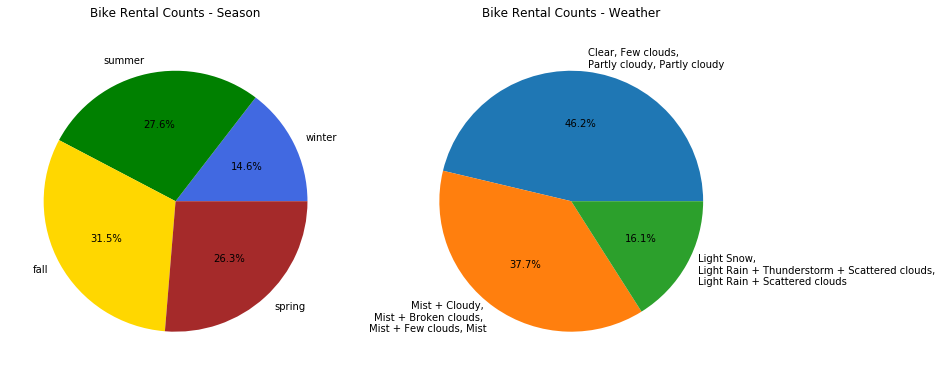

In [10]:
# Looking at how season/weather relate to bike rentals
fig1, axarr1 = plt.subplots(1, 2, figsize=(13, 6))

season_labels = ['winter', 'summer', 'fall', 'spring']
season_values = train_df.groupby('season')['count'].mean()

weather_labels = ['Clear, Few clouds, \nPartly cloudy, Partly cloudy', 'Mist + Cloudy, \nMist + Broken clouds, \nMist + Few clouds, Mist', 'Light Snow, \nLight Rain + Thunderstorm + Scattered clouds, \nLight Rain + Scattered clouds']
weather_values = train_df.groupby('weather')['count'].mean()

season_colors = ['royalblue', 'green', 'gold', 'brown']
axarr1[0].pie(season_values, labels = season_labels, colors = season_colors, autopct='%1.1f%%')
axarr1[0].set_title('Bike Rental Counts - Season\n')

axarr1[1].pie(weather_values, labels = weather_labels, autopct='%1.1f%%')
axarr1[1].set_title('Bike Rental Counts - Weather\n')

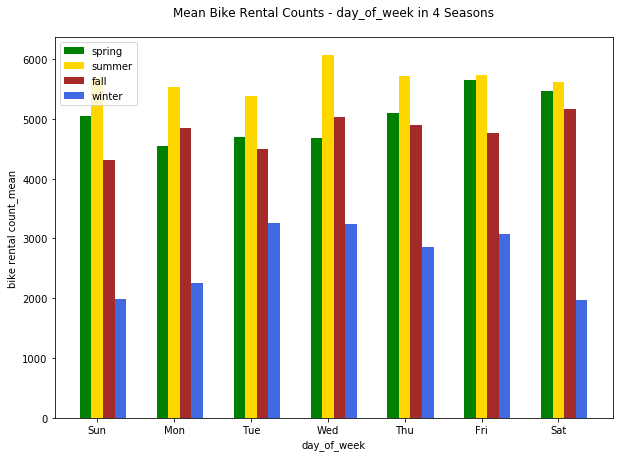

In [11]:
spring_means = []
summer_means = []
fall_means = []
winter_means = []
for k, v in train_df.groupby('day_of_week'):
    winter_means.append(v.loc[v['season']==1.0]['count'].mean()) 
    spring_means.append(v.loc[v['season']==2.0]['count'].mean())
    summer_means.append(v.loc[v['season']==3.0]['count'].mean())
    fall_means.append(v.loc[v['season']==4.0]['count'].mean())
    
bar_width = 0.15
opacity = 1
plt.figure(figsize=(10, 7))
plt.bar(np.arange(len(day_labels)), spring_means, bar_width, alpha=opacity, color='green', label='spring')
plt.bar(np.arange(len(day_labels))+bar_width, summer_means, bar_width, alpha=opacity, color='gold', label='summer')
plt.bar(np.arange(len(day_labels))+bar_width*2, fall_means, bar_width, alpha=opacity, color='brown', label='fall')
plt.bar(np.arange(len(day_labels))+bar_width*3, winter_means, bar_width, alpha=opacity, color='royalblue', label='winter')
                     
plt.xlabel('day_of_week')
plt.ylabel('bike rental count_mean')
plt.title('Mean Bike Rental Counts - day_of_week in 4 Seasons\n')
plt.xticks(np.arange(len(day_labels))+bar_width, day_labels)
plt.legend()

plt.show()

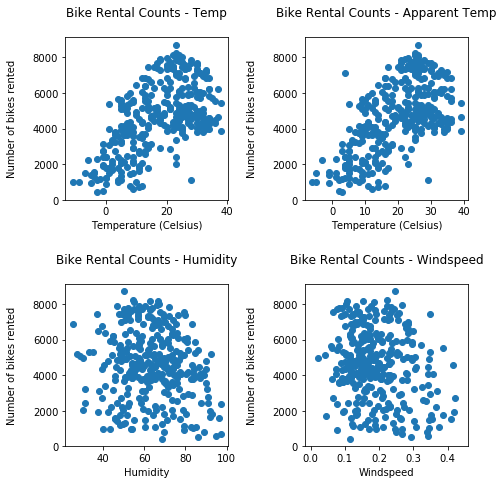

In [12]:
fig2, axarr2 = plt.subplots(2, 2, figsize=(7, 7))

# temperature
axarr2[0,0].scatter(train_df['temp'], train_df['count'])
axarr2[0,0].set_title('Bike Rental Counts - Temp\n')
axarr2[0,0].set_ylabel('Number of bikes rented\n')
axarr2[0,0].set_xlabel('Temperature (Celsius)\n')

# apparent temperature
axarr2[0,1].scatter(train_df['atemp'], train_df['count'])
axarr2[0,1].set_title('Bike Rental Counts - Apparent Temp\n')
axarr2[0,1].set_ylabel('Number of bikes rented\n')
axarr2[0,1].set_xlabel('Temperature (Celsius)\n')

# humidity
axarr2[1,0].scatter(train_df['humidity'], train_df['count'])
axarr2[1,0].set_title('Bike Rental Counts - Humidity\n')
axarr2[1,0].set_ylabel('Number of bikes rented\n')
axarr2[1,0].set_xlabel('Humidity\n')

# windspeed
axarr2[1,1].scatter(train_df['windspeed'], train_df['count'])
axarr2[1,1].set_title('Bike Rental Counts - Windspeed\n')
axarr2[1,1].set_ylabel('Number of bikes rented\n')
axarr2[1,1].set_xlabel('Windspeed\n')

plt.tight_layout()

In [13]:
print('Mean rentals on a rainy/snowy day is: ')
print(train_df.loc[(train_df['weather']==3.0) | (train_df['weather']==4.0)]['count'].mean())
print('Mean rentals of all training data is: ')
print(train_df['count'].mean())

Mean rentals on a rainy/snowy day is: 
1736.2
Mean rentals of all training data is: 
4598.447129909366


your answers here

#### Note: Answers for this part only depend on training data.

- **How does the number of bike rentals vary between weekdays and weekends?**
    Indicated by `workingday`, there are slightly more bike rentals on weekdays/workingdays (4665.896396, 51.1%) than there are on holidays/weekends (4461.073394, 48.9%). 
    
    
- **How about bike rentals on holidays?**
    Indicated by `holiday`, there are slightly less bike rentals on holidays than there are on non-holidays. This trend is similar to what the `workingday` attribute tells.
    

- **What effect does the season have on the bike rentals on a given day?**
    Indicated by `season` (fixed the labeling issue that 1.0=winter, 2.0=spring, 3.0=summer, 4.0=fall), given a day_of_week, bike rentals vary among different seasons. There are least bike rentals in winter, and most in summer.  
    
    
- **Is the number of bike rentals lower than average when there is rain or snow?**
    
    `Mean rentals on a rainy/snowy day is 1736.2`
    
    `Mean rentals of all training data is 4598.447129909366`
    
    Thus, we can say the number of bike rentals is much lower than average when there is rain or snow.
    

- **How does temperature effect bike rentals?**
    Indicated by `temp` and `atemp`, there are more bike rentals when the temperature goes up if it does not get too hot. When the temperature grows beyond a certain point (approximately 25 degree Celcius), bike rentals goes down.
    

- **Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?**
    `temp` and `atemp` indicate a trend that bike rentals firstly go up and then get down. While `humidity` and `windspeed` do not seem to have a clear dependence with bike rentals.


We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [14]:
# your code here
# Convert 'season' into one hot representation - Train Data
season_onehot_train_df = pd.get_dummies(train_df['season'])
del season_onehot_train_df[4.0] # drop the last binary column for 'spring'
season_onehot_train_df = season_onehot_train_df.rename(columns={1.0: 'winter', 2.0: 'spring', 3.0: 'summer'})
train_df_new = pd.concat([train_df, season_onehot_train_df], axis=1)

# Convert 'month' into one hot representation - Train Data
month_onehot_train_df = pd.get_dummies(train_df['month'])
del month_onehot_train_df[12.0] # drop the last binary column for 'December'
month_onehot_train_df = month_onehot_train_df.rename(columns={1.0: 'jan', 2.0: 'feb', 3.0: 'mar', 4.0: 'apr', 5.0: 'may', 6.0: 'jun', 7.0: 'jul', 8.0: 'aug', 9.0: 'sep', 10.0: 'oct', 11.0: 'nov'})
train_df_new = pd.concat([train_df_new, month_onehot_train_df], axis=1)

# Convert 'day_of_week' into one hot representation - Train Data
day_onehot_train_df = pd.get_dummies(train_df['day_of_week'])
del day_onehot_train_df[6.0] # drop the last binary column for 'Sat'
day_onehot_train_df = day_onehot_train_df.rename(columns={0.0: 'sun', 1.0: 'mon', 2.0: 'tue', 3.0: 'wed', 4.0: 'thu', 5.0: 'fri'})
train_df_new = pd.concat([train_df_new, day_onehot_train_df], axis=1)

# Convert 'weather' into one hot representation - Train Data
weather_onehot_train_df = pd.get_dummies(train_df['weather'])
del weather_onehot_train_df[3.0] # drop the last binary column for weather=3.0 (light_snow_rain) 
weather_onehot_train_df = weather_onehot_train_df.rename(columns={1.0: 'clear', 2.0: 'mist'})
train_df_new = pd.concat([train_df_new, weather_onehot_train_df], axis=1)

train_df_new.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,...,oct,nov,sun,mon,tue,wed,thu,fri,clear,mist
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,...,0,0,0,0,1,0,0,0,0,1
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,...,0,0,0,0,1,0,0,0,1,0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,...,0,0,0,0,0,0,1,0,1,0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,...,0,0,1,0,0,0,0,0,1,0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,...,0,0,0,0,0,1,0,0,0,0


In [15]:
# Convert 'season' into one hot representation - Test Data
season_onehot_test_df = pd.get_dummies(test_df['season'])
del season_onehot_test_df[4.0] # drop the last binary column for 'winter'
season_onehot_test_df = season_onehot_test_df.rename(columns={1.0: 'winter', 2.0: 'spring', 3.0: 'summer'})
test_df_new = pd.concat([test_df, season_onehot_test_df], axis=1)

# Convert 'month' into one hot representation - Test Data
month_onehot_test_df = pd.get_dummies(test_df['month'])
del month_onehot_test_df[12.0] # drop the last binary column for 'December'
month_onehot_test_df = month_onehot_test_df.rename(columns={1.0: 'jan', 2.0: 'feb', 3.0: 'mar', 4.0: 'apr', 5.0: 'may', 6.0: 'jun', 7.0: 'jul', 8.0: 'aug', 9.0: 'sep', 10.0: 'oct', 11.0: 'nov'})
test_df_new = pd.concat([test_df_new, month_onehot_test_df], axis=1)

# Convert 'day_of_week' into one hot representation - Test Data
day_onehot_test_df = pd.get_dummies(test_df['day_of_week'])
del day_onehot_test_df[6.0] # drop the last binary column for 'Sat'
day_onehot_test_df = day_onehot_test_df.rename(columns={0.0: 'sun', 1.0: 'mon', 2.0: 'tue', 3.0: 'wed', 4.0: 'thu', 5.0: 'fri'})
test_df_new = pd.concat([test_df_new, day_onehot_test_df], axis=1)

# Convert 'weather' into one hot representation - Test Data
weather_onehot_test_df = pd.get_dummies(test_df['weather'])
del weather_onehot_test_df[3.0] # drop the last binary column for weather=3.0 (light_snow_rain) 
weather_onehot_test_df = weather_onehot_test_df.rename(columns={1.0: 'clear', 2.0: 'mist'})
test_df_new = pd.concat([test_df_new, weather_onehot_test_df], axis=1)

test_df_new.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,...,oct,nov,sun,mon,tue,wed,thu,fri,clear,mist
0,1.0,2.0,0.0,4.0,1.0,1.0,2.0,6.0,56.2083,0.194037,...,0,0,0,0,0,0,1,0,1,0
1,1.0,12.0,0.0,4.0,1.0,2.0,1.0,3.0,65.2917,0.350133,...,0,0,0,0,0,0,1,0,0,1
2,2.0,6.0,0.0,4.0,1.0,2.0,36.0,37.0,56.8333,0.149883,...,0,0,0,0,0,0,1,0,0,1
3,1.0,2.0,0.0,1.0,1.0,1.0,8.0,12.0,49.0833,0.268033,...,0,0,0,1,0,0,0,0,1,0
4,2.0,5.0,0.0,0.0,0.0,1.0,28.0,29.0,69.7083,0.215171,...,0,0,1,0,0,0,0,0,1,0


In [16]:
# Normalize the numeric predictors using mean and std from Train data
train_df_new['temp'] = (train_df['temp'] - train_df['temp'].mean()) / train_df['temp'].std()
train_df_new['atemp'] = (train_df['atemp'] - train_df['atemp'].mean()) / train_df['atemp'].std()
train_df_new['humidity'] = (train_df['humidity'] - train_df['humidity'].mean()) / train_df['humidity'].std()
train_df_new['windspeed'] = (train_df['windspeed'] - train_df['windspeed'].mean()) / train_df['windspeed'].std()

# Normalize the numeric predictors: temp, atemp, humidity, windspeed - Test data
test_df_new['temp'] = (test_df['temp'] - train_df['temp'].mean()) / train_df['temp'].std()
test_df_new['atemp'] = (test_df['atemp'] - train_df['atemp'].mean()) / train_df['atemp'].std()
test_df_new['humidity'] = (test_df['humidity'] - train_df['humidity'].mean()) / train_df['humidity'].std()
test_df_new['windspeed'] = (test_df['windspeed'] - train_df['windspeed'].mean()) / train_df['windspeed'].std()

In [17]:
test_df_new.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,...,oct,nov,sun,mon,tue,wed,thu,fri,clear,mist
0,1.0,2.0,0.0,4.0,1.0,1.0,-1.341801,-1.363792,-0.500703,0.040945,...,0,0,0,0,0,0,1,0,1,0
1,1.0,12.0,0.0,4.0,1.0,2.0,-1.431146,-1.665877,0.132958,2.036025,...,0,0,0,0,0,0,1,0,0,1
2,2.0,6.0,0.0,4.0,1.0,2.0,1.695943,1.757749,-0.457103,-0.523392,...,0,0,0,0,0,0,1,0,0,1
3,1.0,2.0,0.0,1.0,1.0,1.0,-0.805728,-0.759623,-0.997746,0.986696,...,0,0,0,1,0,0,0,0,1,0
4,2.0,5.0,0.0,0.0,0.0,1.0,0.981180,0.952190,0.441062,0.311061,...,0,0,1,0,0,0,0,0,1,0


In [47]:
# Find predictors & the response
month_p = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov']
day_p = ['sun', 'mon', 'tue', 'wed', 'thu', 'fri']
season_p = ['winter', 'spring', 'summer']
weather_p = ['clear', 'mist']
response = ['count']
all_predictors = month_p + day_p + season_p + weather_p + ['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed']


# Update training and test data 
train_df_new = train_df_new[all_predictors + response]
test_df_new = test_df_new[all_predictors + response]

In [48]:
# Summarize statistics of the new attributes - Training data
train_df_new.describe()

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,...,summer,clear,mist,holiday,workingday,temp,atemp,humidity,windspeed,count
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,331.000000
mean,0.078550,0.066465,0.075529,0.078550,0.102719,0.072508,0.093656,0.081571,0.099698,0.090634,...,0.265861,0.640483,0.329305,0.033233,0.670695,-6.976628e-17,-1.227618e-16,-7.808457e-16,1.543579e-15,4598.447130
std,0.269442,0.249471,0.264643,0.269442,0.304051,0.259719,0.291790,0.274124,0.300050,0.287523,...,0.442459,0.480585,0.470672,0.179515,0.470672,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1935.319338
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-2.503291e+00,-2.572131e+00,-2.648736e+00,-2.152869e+00,431.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-8.504011e-01,-8.603176e-01,-7.452412e-01,-7.381149e-01,3370.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,8.772587e-02,1.466312e-01,-6.562743e-03,-1.579037e-01,4648.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,8.024892e-01,7.508005e-01,7.055719e-01,5.693478e-01,5981.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.874634e+00,1.959139e+00,2.362380e+00,2.949989e+00,8714.000000


In [49]:
# Summarize statistics of the new attributes - Test data
test_df_new.describe()

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,...,summer,clear,mist,holiday,workingday,temp,atemp,humidity,windspeed,count
count,400.00000,400.00000,400.000000,400.000000,400.000000,400.00000,400.000000,400.00000,400.0000,400.000000,...,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000
mean,0.09000,0.08750,0.092500,0.085000,0.070000,0.09000,0.077500,0.08750,0.0675,0.080000,...,0.250000,0.627500,0.345000,0.02500,0.695000,-0.128713,-0.121217,-0.076029,-0.008111,4514.21250
std,0.28654,0.28292,0.290093,0.279231,0.255467,0.28654,0.267718,0.28292,0.2512,0.271633,...,0.433555,0.484076,0.475964,0.15632,0.460984,1.052309,1.061183,0.988182,0.983825,2092.60635
min,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,-2.324601,-2.370741,-4.421814,-1.858750,22.00000
25%,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,-1.073765,-1.061707,-0.879771,-0.714163,2875.25000
50%,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,...,0.000000,1.000000,0.000000,0.00000,1.000000,-0.180310,-0.155453,-0.092312,-0.098286,4516.00000
75%,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0000,0.000000,...,0.250000,1.000000,1.000000,0.00000,1.000000,0.802489,0.851495,0.665606,0.534842,6174.75000
max,1.00000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.0000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.963980,2.261224,2.202511,4.046877,10045.00000


your answers here

**Why can't categorical attributes be directly used as predictors?**
Different values of these categorical attributes indicate different classes. Non-binary categorical attributes cannot be aggregated (sum/avg/min/mix...) to reflect data statistics.

** Why is it okay to not have a binary column for the $K_j$-th category? **
The firt j-1 categories are represented as a '_one_' value at some location. Then, the last category is represented using all '_zero_'s.

** Why shouldn't we include the test set observations in computing the mean and SD? **
We want our model to be trained solely on the training set. Test data should be researved for model evaluation. Using observations from test set to calculate mean and SD leaks test information, thus compromising the credibility of testing results.

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [50]:
# your code here
# Build the training and test sets
x_train = train_df_new[all_predictors]
x_test = test_df_new[all_predictors]
y_train = train_df_new['count']
y_test = test_df_new['count']
x_train.head()
X_train = sm.add_constant(x_train)
X_test = sm.add_constant(x_test)

# Build the OLS model (ordinary least squares) from the training data
multi_linear_model = sm.OLS(y_train, X_train)
results_multi_linear = multi_linear_model.fit()

# Predict results
y_pred_train = results_multi_linear.predict(X_train)
y_pred_test = results_multi_linear.predict(X_test)

# Evaluate 
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print('R2 score on train set: ', r2_train)
print('R2 score on test set: ', r2_test)

R2 score on train set:  0.576128178313
R2 score on test set:  0.249342111465


In [51]:
# Print the t-statistic values for all predictors.
results_multi_linear.tvalues

const         5.526960
jan           0.235154
feb           0.402498
mar           0.700085
apr           0.687428
may           0.075641
jun          -0.967370
jul          -1.655806
aug          -0.960579
sep           0.955674
oct           1.375685
nov           0.559267
sun          -1.728171
mon          -1.486315
tue          -1.602389
wed           0.175012
thu          -0.343879
fri          -0.108755
winter       -2.419645
spring       -0.570933
summer       -0.430360
clear         2.989246
mist          3.271494
holiday      -1.522219
workingday   -0.138353
temp          1.950818
atemp         0.726613
humidity     -4.845341
windspeed    -3.158772
dtype: float64

In [52]:
predictor_pvals = results_multi_linear.pvalues
print('significant p-values: \n', predictor_pvals[predictor_pvals<0.05])

significant p-values: 
 const        7.031215e-08
winter       1.612408e-02
clear        3.025734e-03
mist         1.193294e-03
humidity     2.020827e-06
windspeed    1.744235e-03
dtype: float64


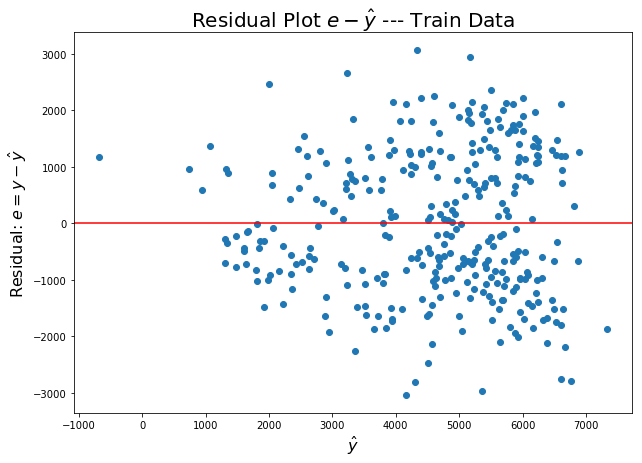

In [57]:
# Residual plot
fig3, ax3 = plt.subplots(1, 1, figsize=(10, 7))
e = y_train - y_pred_train

ax3.scatter(x=y_pred_train, y=e)
plt.axhline(y = 0, color='r', linestyle='-')
plt.title('Residual Plot $e-\hat{y}$ --- Train Data' , fontsize=20)
plt.xlabel('$\hat{y}$', fontsize=16)
plt.ylabel('Residual: ${e} = y - \hat{y}$', fontsize=16)


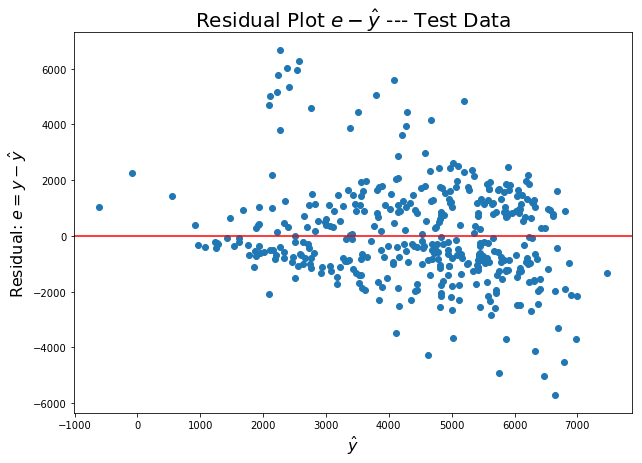

In [58]:
# Residual plot
fig4, ax4 = plt.subplots(1, 1, figsize=(10, 7))
e_test = y_test - y_pred_test

ax4.scatter(x=y_pred_test, y=e_test)
plt.axhline(y = 0, color='r', linestyle='-')
plt.title('Residual Plot $e-\hat{y}$ --- Test Data' , fontsize=20)
plt.xlabel('$\hat{y}$', fontsize=16)
plt.ylabel('Residual: ${e} = y - \hat{y}$', fontsize=16)

your answers here

- **report $R^2$ score on the test set** 

    - `R2 score on train set:  0.576128178313`

    - `R2 score on test set:  0.249342111465`

- **Statistical significance**
    
    - The predictors associated with a positive slope value have positive correlation with the number of bike rentals, which are `jan`, `feb`, `mar`, `apr`, `may`, `sep`, `oct`, `nov`, `wed`, `clear`, `mist`, `clear`, `mist`, `temp`, `atemp`. 
    
    - Not a single day_of_week has been picked out by the t-test with a significant p-value. Thus, we can say that the day of a week does not really have an apparent relationship with bike rentals.
    
    - No months are picked out by the t-test, but `winter` is tested to be a significant predictor. 
    
    - `holiday` is not tested to be a significant predictor for bike rentals. 
    
    - The coefficients assigned to `temp` and `atemp` are different, but neither of them is tested to be a significant predictor for bike rentals. They seem to be correlated. The one with larger coefficient could be relatively more significant relating to bike rentals.

- **Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?** 
    
    - Yes. A non-linear relationship between the predictors and response is revealed since residual plots for both training and test data show that the residuals are not uniformly distributed for different predicted y values. The variance of the error grows as the predicted y value grows.



## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

In [59]:
train_df_new.T

,0,1,2,3,4,5,6,7,8,9,...,321,322,323,324,325,326,327,328,329,330
jan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
feb,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
mar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
apr,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
may,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
jun,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
jul,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
aug,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
sep,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
oct,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


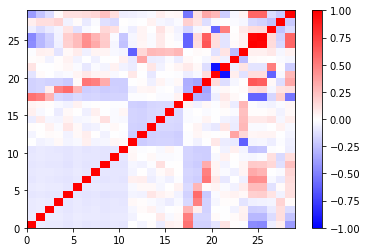

In [60]:
# your code here
correlation_matrix = np.corrcoef(train_df_new.T)
plt.pcolor(correlation_matrix, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()

your answers here

- **Does the data suffer from multi-collinearity?** 

    - From the heatmap of the correlation matrix above, the data clearly suffers from multi-collinearity. 

    - Most apparently, `temp`(#24) and `atemp`(#25) are linearly correlated. 

    - `temp` is also linearly corelated with some weather and some month. 

    - `clear`(#20) and `mist`(#21) have obvious negative linear correlation. 

    - All the binary predictors resulting from one-hot encoding clearly fall into natrual groups (month: #0-#10, day_of_week: #11-#16, season: #17-#19, weather: #20-#21)

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




#### Forward predictors selection using BIC
Reference: Lecture_6_Notebook

In [61]:
predictor_sets_with_score = [([], 0)]

# Build the OLS model (ordinary least squares) from the training data
multi_linear_model = sm.OLS(y_train, X_train)
results_multi_linear = multi_linear_model.fit()

# Forward selection process 
for k in range(1, len(all_predictors)): 
    best_k_minus_1 = predictor_sets_with_score[-1][0]

    new_predictors = list(set(all_predictors) - set(best_k_minus_1))
    BIC = []

    for predictor in new_predictors:

        k_predictors = best_k_minus_1 + [predictor]
        
        X_train = train_df_new[k_predictors].values
        
        if k == 1:
            X_train = X_train.reshape((len(X_train), 1))
        
        # Build & fit the OLS model
        regressions_model = sm.OLS(y_train, X_train) # y_train = train_df_new(response)
        results = regressions_model.fit()
        # Get BIC score in sample
        BIC.append(results.bic)
    
    best_k = best_k_minus_1 + [new_predictors[np.argmin(BIC)]]
    predictor_sets_with_score.append((best_k, np.min(BIC)))

X_train = train_df_new[all_predictors].values
regressions_model = sm.OLS(y_train, X_train) # y_train = train_df_new(response)
results = regressions_model.fit()
predictor_sets_with_score.append((all_predictors, results.bic))

# Sort all possible predictor_sets by BIC and take the one with the smallest BIC
# Index = 1: Exclude the empty predictors set (BIC=0)
forward_best_predictor_set = sorted(predictor_sets_with_score, key=lambda t: t[1])[1]
print('Best set of forward selected predictors and its BIC metric:')
forward_best_predictor_set

Best set of forward selected predictors and its BIC metric:


(['clear', 'mist', 'atemp', 'winter', 'sep', 'oct'], 5770.188969866972)

In [62]:
# The set of predictors selected by forward selection
forward_selected_X_train = sm.add_constant(train_df_new[forward_best_predictor_set[0]].values)
forward_selected_X_test = sm.add_constant(test_df_new[forward_best_predictor_set[0]].values)

# Fit the selected model
forward_selected_model = sm.OLS(y_train, forward_selected_X_train)
forward_selected_results = forward_selected_model.fit()

# Predict results
forward_selected_y_pred_train = forward_selected_results.predict(forward_selected_X_train)
forward_selected_y_pred_test = forward_selected_results.predict(forward_selected_X_test)

# Evaluate 
forward_selected_r2_train = r2_score(y_train, forward_selected_y_pred_train)
forward_selected_r2_test = r2_score(y_test, forward_selected_y_pred_test)
print('After forward selection, ')
print('R2 score on train set: ', forward_selected_r2_train)
print('R2 score on test set: ', forward_selected_r2_test)

After forward selection, 
R2 score on train set:  0.510741757476
R2 score on test set:  0.274205467482


#### Backward predictors selection using BIC
Reference: Lecture_6_Notebook

In [63]:
all_predictors_X_train = train_df_new[all_predictors].values
all_predictors_model = sm.OLS(y_train, all_predictors_X_train)
all_predictors_results = all_predictors_model.fit()

predictor_sets_with_score = [(all_predictors, all_predictors_results.bic)]

for k in range(len(all_predictors), 1, -1):
    best_k_predictors = predictor_sets_with_score[-1][0]
    BIC = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = train_df_new[k_minus_1].values
        
        model = sm.OLS(y_train, X_train)
        results = model.fit()
        BIC.append(results.bic)
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(BIC)]]))
    predictor_sets_with_score.append((best_k_minus_1, np.min(BIC)))

back_best_predictor_set = sorted(predictor_sets_with_score, key=lambda t: t[1])[0]
print('Best set of backward selected predictors and its BIC metric:')
back_best_predictor_set

Best set of backward selected predictors and its BIC metric:


(['nov', 'temp', 'clear', 'oct', 'sep', 'apr', 'mist'], 5775.5927964427492)

In [64]:
# The set of predictors selected by backward selection
back_selected_X_train = sm.add_constant(train_df_new[back_best_predictor_set[0]].values)
back_selected_X_test = sm.add_constant(test_df_new[back_best_predictor_set[0]].values)

# Fit the selected model
back_selected_model = sm.OLS(y_train, back_selected_X_train)
back_selected_results = back_selected_model.fit()

# Predict results
back_selected_y_pred_train = back_selected_results.predict(back_selected_X_train)
back_selected_y_pred_test = back_selected_results.predict(back_selected_X_test)

# Evaluate 
back_selected_r2_train = r2_score(y_train, back_selected_y_pred_train)
back_selected_r2_test = r2_score(y_test, back_selected_y_pred_test)
print('After backward selection, ')
print('R2 score on train set: ', back_selected_r2_train)
print('R2 score on test set: ', back_selected_r2_test)

After backward selection, 
R2 score on train set:  0.496695366445
R2 score on test set:  0.237408741424


your answers here

- Forward and backward selection gives 6 and 7 predictors respectively. As compared to the model with all 28 predictors, they do eliminate redundant predictors. For instance, the closely related `atemp` and `temp` cannot both appear.

- The test $R^2$ scores for the fitted models _(forward: 0.274, backward: 0.237)_ are no worse compare with the all predictors model _(all-predictors: 0.249)_.


## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Fit each of the 3 models on the provided left out test set and calculate $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [67]:
# your code here
from sklearn.model_selection import KFold
n_folds = 10
kfold = KFold(n_folds, shuffle = True)

train_r2 = np.zeros((3, n_folds))
valid_r2 = np.zeros((3, n_folds))

fold = 0
for train, valid in KFold(n_folds, shuffle=True).split(range(len(train_df_new))):
    
    # Make features for the 3 models
    forward_X_train = sm.add_constant(train_df_new.iloc[train][forward_best_predictor_set[0]].values)
    forward_X_valid = sm.add_constant(train_df_new.iloc[valid][forward_best_predictor_set[0]].values)
    
    back_X_train = sm.add_constant(train_df_new.iloc[train][back_best_predictor_set[0]].values)
    back_X_valid = sm.add_constant(train_df_new.iloc[valid][back_best_predictor_set[0]].values)
    
    all_X_train = sm.add_constant(train_df_new.iloc[train][all_predictors].values)
    all_X_valid = sm.add_constant(train_df_new.iloc[valid][all_predictors].values)
    
    # Fit the 3 models
    results_forward = sm.OLS(y_train.iloc[train], forward_X_train).fit()
    results_back = sm.OLS(y_train.iloc[train], back_X_train).fit()
    results_all = sm.OLS(y_train.iloc[train], all_X_train).fit()
    
    # Calculate R2 scores in the order:
    # 0: forward
    train_r2[0, fold] = r2_score(y_train.iloc[train], results_forward.predict(forward_X_train))
    valid_r2[0, fold] = r2_score(y_train.iloc[valid], results_forward.predict(forward_X_valid))
    # 1: backward
    train_r2[1, fold] = r2_score(y_train.iloc[train], results_back.predict(back_X_train))
    valid_r2[1, fold] = r2_score(y_train.iloc[valid], results_back.predict(back_X_valid))
    # 2: all
    train_r2[2, fold] = r2_score(y_train.iloc[train], results_all.predict(all_X_train))
    valid_r2[2, fold] = r2_score(y_train.iloc[valid], results_all.predict(all_X_valid))
    
    fold += 1

mean_train_r2 = train_r2.mean(axis=1)
print('mean r2 on train data: ')
mean_train_r2

mean r2 on train data: 


array([ 0.51135225,  0.49769915,  0.58149832])

In [68]:
mean_valid_r2 = valid_r2.mean(axis=1)
print('mean r2 on validation data: ')
mean_valid_r2

mean r2 on validation data: 


array([ 0.47818384,  0.45423567,  0.38884321])

In [74]:
# Make features for the 3 models -Test data
forward_X_test = sm.add_constant(test_df_new[forward_best_predictor_set[0]].values)
back_X_test = sm.add_constant(test_df_new[back_best_predictor_set[0]].values)
all_X_test = sm.add_constant(test_df_new[all_predictors].values)

# Fit the 3 models -Test data
results_forward = sm.OLS(y_test, forward_X_test).fit()
results_back = sm.OLS(y_test, back_X_test).fit()
results_all = sm.OLS(y_test, all_X_test).fit()

# Calculate R2 scores -Test data
forward_r2_test = r2_score(y_test, results_forward.predict(forward_X_test))
back_r2_test = r2_score(y_test, results_back.predict(back_X_test))
all_r2_test = r2_score(y_test, results_all.predict(all_X_test))

print(forward_r2_test, back_r2_test, all_r2_test)

0.297975650663 0.286601363413 0.357710855043


your answers here

- **Report the average $R^2$ across all 10 validation sets for each model**
    - forward: `0.47818384`
    - backward: `0.45423567`  
    - all_predictors: `0.38884321`


- **Why do you think this is the case**
    - The average $R^2$ across all 10 validation sets for the forward/backward selected models are higher than the model using all predictors. This is because forward/backward selection found out the most informative predictors in the training data and eliminated redundant information. 
    

- **$R^2$ of the three model on test set**
    - forward: `0.274205467482`
    - backward: `0.237408741424`
    - all_predictors: `0.249342111465`
    

- **Do the results agree with the cross-validation? Why or why not?**
    - Yes, the results **mostly** agree with the cross-validation. The slight difference could be explained as that we did forward/backward selection on training data but not test data. Some useful information in the test set was not seen by the stepwise selection process.